In [212]:
import os
import gemmi
import reciprocalspaceship as rs

import numpy as np
from sklearn.decomposition import NMF
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

import masks
import models

from importlib import reload
reload(models)

<module 'models' from '/Users/tjlane/opt/mmcpd-scripts/models.py'>

In [213]:
def latex_float(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [214]:
# parameters

#MASK = lambda map : map  ; MASK_NAME = 'none'
#MASK = lambda map : masks.mask_solvent(PDB, map)  ; MASK_NAME = 'solvent'


#MASK = masks.FDA_and_TT_chainA_region_only  ; MASK_NAME = 'TT+FAD_region'

In [241]:
# base_path = '/Users/tjlane/Desktop/PL-workshop/pdb-depositions/'
# timepoints = {
#          0.0 : '1_superdark/superdark_deposit.mtz',
#          3.0 : '2_3ps/3ps_deposit.mtz',
#        300.0 : '3_300ps/300ps_deposit.mtz',
#       1000.0 : '4_1ns/1ns_deposit.mtz',
#       3000.0 : '5_3ns/3ns_deposit.mtz',
#      10000.0 : '6_10ns/10ns_deposit.mtz',
#      30000.0 : '7_30ns/30ns_deposit.mtz',
#    1000000.0 : '8_1us/1us_deposit.mtz',
#   10000000.0 : '9_10us/10us_deposit.mtz',
#   30000000.0 : '10_30us/30us_deposit.mtz',
#  100000000.0 : '11_100us/100us_deposit.mtz',
# }

base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/polder/ttd_chainA/'
MASK = masks.TT_chainA_region_only
MASK_NAME = 'TT_region'
timepoints = {
         0.0 : 'superdark_deposit_polder_map_coeffs.mtz',
         3.0 : '3ps_deposit_polder_map_coeffs.mtz',
       300.0 : '300ps_deposit_polder_map_coeffs.mtz',
      1000.0 : '1ns_deposit_polder_map_coeffs.mtz',
      3000.0 : '3ns_deposit_polder_map_coeffs.mtz',
     10000.0 : '10ns_deposit_polder_map_coeffs.mtz',
     30000.0 : '30ns_deposit_polder_map_coeffs.mtz',
   1000000.0 : '1us_deposit_polder_map_coeffs.mtz',
  10000000.0 : '10us_deposit_polder_map_coeffs.mtz',
  30000000.0 : '30us_deposit_polder_map_coeffs.mtz',
 100000000.0 : '100us_deposit_polder_map_coeffs.mtz',
}

base_path = '/Users/tjlane/Desktop/PL-workshop/nmf/intensity_polder/ttd_chainB/'
MASK = masks.TT_chainB_region_only
MASK_NAME = 'TT_region-B'
timepoints = {
         0.0 : 'superdark_deposit_polder_map_coeffs.mtz',
         3.0 : '3ps_deposit_polder_map_coeffs.mtz',
       300.0 : '300ps_deposit_polder_map_coeffs.mtz',
      1000.0 : '1ns_deposit_polder_map_coeffs.mtz',
      3000.0 : '3ns_deposit_polder_map_coeffs.mtz',
     10000.0 : '10ns_deposit_polder_map_coeffs.mtz',
     30000.0 : '30ns_deposit_polder_map_coeffs.mtz',
   1000000.0 : '1us_deposit_polder_map_coeffs.mtz',
  10000000.0 : '10us_deposit_polder_map_coeffs.mtz',
  30000000.0 : '30us_deposit_polder_map_coeffs.mtz',
 100000000.0 : '100us_deposit_polder_map_coeffs.mtz',
}


#MASK = masks.FDA_chainA_region_only  ; MASK_NAME = 'FAD_region'

for k in timepoints.keys():
    timepoints[k] = base_path + timepoints[k]
    if not os.path.exists(timepoints[k]):
        print('cant find', k)

In [242]:
# load all Fs and sigFs into one big rs table
tps = sorted(timepoints.keys())
maps = []

for tp in tps:

    ds = rs.read_mtz(timepoints[tp]) 
    ds.compute_dHKL(inplace=True)

    gemmi_mtz = ds.to_gemmi()
    #grid = gemmi_mtz.transform_f_phi_to_map('2FOFCWT', 'PH2FOFCWT', exact_size=(180, 300, 432))
    grid = gemmi_mtz.transform_f_phi_to_map('mFo-DFc_polder', 'PHImFo-DFc_polder', exact_size=(180, 300, 432))

    map = MASK(grid)
    map = np.array(map)
    
    MAP_SHAPE = map.shape
    maps.append(map.flatten())

    fraction_of_zeros = np.sum(map == 0) / float(np.product(map.shape))
    print( MAP_SHAPE, np.min(ds['dHKL']), np.max(ds['dHKL']), fraction_of_zeros)


maps = np.array(maps)
#assert maps.min() > -1e-32, maps.min()
print(maps.shape)

(180, 300, 432) 2.107942 32.45577 0.993912037037037
(180, 300, 432) 2.1622956 31.289146 0.993912037037037
(180, 300, 432) 2.350099 30.97964 0.993912037037037
(180, 300, 432) 2.2747512 31.289146 0.993912037037037
(180, 300, 432) 2.3459172 31.788992 0.993912037037037
(180, 300, 432) 2.3633437 31.289146 0.993912037037037
(180, 300, 432) 2.390934 31.788992 0.993912037037037
(180, 300, 432) 2.2414005 31.289146 0.993912037037037
(180, 300, 432) 2.1827593 31.788992 0.993912037037037
(180, 300, 432) 2.2473514 31.289146 0.993912037037037
(180, 300, 432) 2.5000052 30.668371 0.993912037037037
(11, 23328000)


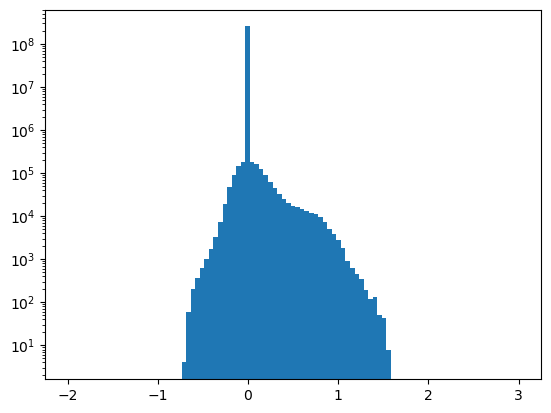

In [243]:
plt.figure()
plt.hist(maps.flatten(), bins=np.linspace(-2, 3, 100))
plt.yscale('log')
plt.show()

In [244]:
maps[maps < 0] = 0.0

In [245]:
# reconstruction_errors = []

# for n_components in range(1, 10):
#     model = NMF(n_components=n_components, init='random', random_state=0)
#     model.fit(fda_maps)
#     reconstruction_errors.append(model.reconstruction_err_)

In [246]:
# plt.figure()
# plt.plot(np.arange(1,10), reconstruction_errors)
# plt.xlabel('number of components')
# plt.ylabel('reconstruction error')
# plt.show()

In [247]:
N_COMPONENTS = 3

model = NMF(n_components=N_COMPONENTS, init='random', random_state=0)
W = model.fit_transform(np.abs(maps))
H = model.components_

In [ ]:
times = sorted(timepoints.keys())
populations = W / W.sum(axis=1)[:,None]

# we need to re-order the states so they appear in the order they are populated
populations = populations[:, np.array([1,2,0])]
#populations = populations[ :, np.array([0,2,3,1])]

lk_model = models.LinearKinetic(n_states=N_COMPONENTS, times=times, populations=populations)
k_opt = lk_model.fit(k0=[1e-4,] * (N_COMPONENTS-1))
print('timescales (ns):', 1e-3 / k_opt)

residual: 0.4029873110296479
timescales (ns): [1.23440899e+00 1.56744249e+04]


/opt/homebrew/Caskroom/miniforge/base/envs/rs/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


81.07767783890952


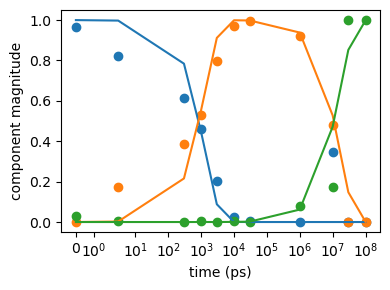

In [234]:
print(model.reconstruction_err_)

plt.figure(figsize=(4,3))

plt.plot(times, populations, 'o')
plt.gca().set_prop_cycle(None)
plt.plot(times, lk_model.estimate(times, k_opt))

plt.xlabel('time (ps)')
plt.xscale('symlog')
plt.ylabel('component magnitude')

plt.tight_layout()
plt.savefig(f'/Users/tjlane/Desktop/PL-workshop/nmf/plots/populations_{MASK_NAME}.png')
plt.savefig(f'/Users/tjlane/Desktop/PL-workshop/nmf/plots/populations_{MASK_NAME}.pdf')
plt.show()

In [224]:
output_path = '/Users/tjlane/Desktop/PL-workshop/nmf/components/'

for i in range(N_COMPONENTS):
    component_grid = gemmi.FloatGrid(H[i,:].reshape(MAP_SHAPE))
    masks.grid_to_PL_map(
        component_grid, 
        output_path + f'nmf_mask{MASK_NAME}_comp{i}.ccp4'
    )